In [1]:
# import os

# if os.path.exists("/etc/pki/ca-trust/extracted/pem/tls-ca-bundle.pem"):
#     os.environ["TENSORSTORE_CA_BUNDLE"] = "/etc/pki/ca-trust/extracted/pem/tls-ca-bundle.pem"

In [1]:
from microsim import schema as ms
import numpy as np
import math

In [2]:
# Define a simple Filter through a function that allows us to set min and max values for the spectrum
def create_custom_channel(
    min_wave: int = 300, 
    max_wave: int = 800,
) -> list[ms.optical_config.OpticalConfig]:

    custom_spectrum = ms.Spectrum(
        wavelength=np.arange(min_wave, max_wave, 1),
        intensity=np.arange(min_wave, max_wave, 1),
    )

    custom_filter = ms.optical_config.SpectrumFilter(transmission=custom_spectrum) # placement=ALL by default

    custom_channel = ms.optical_config.OpticalConfig(
        name="FEDERICO",
        filters=[custom_filter],
    )
    
    return custom_channel

In [3]:
my_ch = create_custom_channel()

print(my_ch.filters[0].spectrum)
print(my_ch.filters[0].spectrum.wavelength.shape, type(my_ch.filters[0].spectrum.wavelength))
print(my_ch.filters[0].spectrum.intensity.shape, type(my_ch.filters[0].spectrum.intensity), max(my_ch.filters[0].spectrum.intensity))

wavelength=ndarray<shape=(500,) dtype=int64 units=nanometer> intensity=ndarray<shape=(500,) dtype=float64> scalar=1.0
(500,) <class 'pint.registry.Quantity'>
(500,) <class 'numpy.ndarray'> 1.0


/localscratch/miniforge3/envs/microsim_env/lib/python3.11/site-packages/pydantic/main.py:176: UserWarning: Normalize intensity to 1
  self.__pydantic_validator__.validate_python(data, self_instance=self)


In [4]:
from microsim.schema.optical_config import lib

sim = ms.Simulation(
    truth_space=ms.ShapeScaleSpace(shape=(52, 512, 512), scale=(0.064, 0.064, 0.064)),
    output_space={"downscale": 2},
    sample=ms.Sample(
        labels=[
            ms.FluorophoreDistribution(
                distribution=ms.CosemLabel(dataset="jrc_hela-3", label="ne_pred"),
                fluorophore="mTurquoise",
            ),
            ms.FluorophoreDistribution(
                distribution=ms.CosemLabel(dataset="jrc_hela-3", label="er-mem_pred"),
                fluorophore="EYFP",
            ),
            ms.FluorophoreDistribution(
                distribution=ms.CosemLabel(dataset="jrc_hela-3", label="mito-mem_pred"),
                fluorophore="mScarlet",
            ),
        ]
    ),
    channels=[create_custom_channel(min_wave=300, max_wave=800)],
    modality=ms.Confocal(pinhole_au=2),
    detector=ms.CameraCCD(qe=0.82, read_noise=6),
    output_path="h2-cf.tif",
    settings=ms.Settings(max_psf_radius_aus=2),
    emission_bins=32
)

In [5]:
# from microsim.schema.optical_config.lib import EYFP, FITC

# sim = ms.Simulation(
#     truth_space=ms.ShapeScaleSpace(shape=(64, 256, 256), scale=(0.04, 0.02, 0.02)),
#     output_space={"downscale": 4},
#     sample=ms.Sample(
#         labels=[
#             ms.FluorophoreDistribution(
#                 distribution=ms.MatsLines(density=1, length=8, azimuth=1, max_r=math.sqrt(2)),
#                 fluorophore="EGFP",
#             ),
#             ms.FluorophoreDistribution(
#                 distribution=ms.MatsLines(density=0.1, length=30, azimuth=50, max_r=math.sqrt(2)),
#                 fluorophore="EYFP",
#             ),
#         ]
#     ),
#     modality=ms.Confocal(pinhole_au=1),
#     settings=ms.Settings(random_seed=100, max_psf_radius_aus=4),
#     detector=ms.CameraCCD(qe=0.82, read_noise=4, bit_depth=12),
#     # channels=[FITC, EYFP],
#     channels=[create_custom_channel(min_wave=300, max_wave=800)],
#     emission_bins=32,
#     # binning_strategy="equal_space"
# )

### Ground truth generation

The ground truth stage is responsible for generating the positions of the fluorophores in the 3D space. Each [FluorophoreDistribution][microsim.schema.FluorophoreDistribution] object in the simulation specifies the position, number, species (e.g. mEGFP) of fluorophores in the volume. The ground truth will have dimensions (F, Z, Y, X) where len(F) is determined by the number of labels in the sample field of the Simulation; the values in the ground truth array represent the number of fluorophores present at each voxel in the volume.

In [6]:
gt = sim.ground_truth()
print(gt.shape, gt.coords) # (F, Z, Y, X)

I0000 00:00:1719174165.282127   63423 s3_resource.cc:108] Using default AdmissionQueue with limit 32
W0000 00:00:1719174165.999563   63628 curl_transport.cc:452] Error [28]=Timeout was reached in curl operation
Failed to connect to 169.254.169.254 port 80 after 200 ms: Timeout was reached
W0000 00:00:1719174172.771934   63628 curl_transport.cc:452] Error [28]=Timeout was reached in curl operation
Failed to connect to 169.254.169.254 port 80 after 200 ms: Timeout was reached
W0000 00:00:1719174183.009254   63628 curl_transport.cc:452] Error [28]=Timeout was reached in curl operation
Failed to connect to 169.254.169.254 port 80 after 200 ms: Timeout was reached


(3, 52, 512, 512) Coordinates:
  * z        (z) float64 416B 0.0 0.064 0.128 0.192 ... 3.072 3.136 3.2 3.264
  * y        (y) float64 4kB 0.0 0.064 0.128 0.192 ... 32.51 32.58 32.64 32.7
  * x        (x) float64 4kB 0.0 0.064 0.128 0.192 ... 32.51 32.58 32.64 32.7
  * f        (f) object 24B distribution=CosemLabel(type='cosem', dataset='jr...


In [7]:
# Count number of fluorophores per pixel
print(int(np.sum(gt[0, ...] == 0))) # What does it change to have more than 1 fluorophore per pixel? Twice the emission intensity there?
print(int(np.sum(gt[0, ...] == 1)))
print(int(np.sum(gt[0, ...] == 2)))
print(int(np.sum(gt[0, ...] == 10)))

11059127
1033813
341326
20379


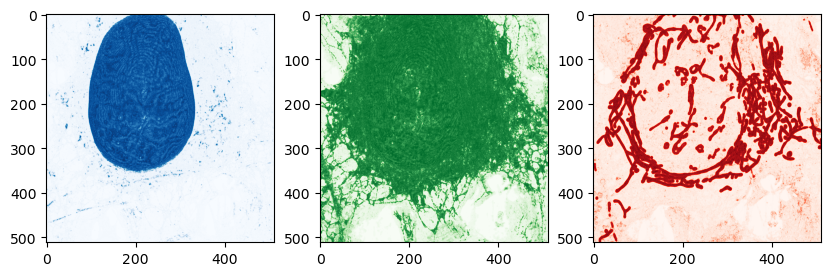

In [8]:
# Print the fluorophore distribution
import matplotlib.pyplot as plt

# Make MIP over z-axis
gt_mip = gt.max(dim='z')

cmaps = ["Blues", "Greens", "Reds", "Grays"]
_, ax = plt.subplots(1, gt_mip.shape[0], figsize=(10, 5))
for i in range(gt_mip.shape[0]):
    ax[i].imshow(gt_mip[i, ...], cmap=cmaps[i])

Question: how is the Flurophore distribution generated? -> Look into `ms.FluorophoreDistribution`!

### Get the emission spectra (common approach)

In [8]:
emission_imgs = []
channels = tuple(range(len(sim.channels)))
for channel_idx in channels:
    emission_imgs.append(sim.emission_flux(gt, channel_idx=channel_idx))
    
print(len(emission_imgs), emission_imgs[0].shape) # shape should be (W, C, F, Z, Y, X), with C=1 for simplicity

1 (64, 1, 2, 64, 256, 256)


In [ ]:
emission_imgs[0]["w"]

### Get the emission spectra (new approach)

Idea:
1. Get the emission spectrum for each fluorophore.
2. Get min and max wavelength over all the spectra.
3. Create the same bins for all the spectra, using common min and max wavelength and number of bins.

In [9]:
# emission_imgs = []
# channels = tuple(range(len(sim.channels)))
# for channel_idx in channels:
#     emission_imgs.append(sim.spectral_emission_flux(gt, channel_idx=channel_idx))

In [10]:
channel = sim.channels[0]
em_img, em_spectra, em_binned_spectra = sim.spectral_emission_flux(gt, channel_idx=0)

Print histograms of spectra and binned spectra for testing

In [11]:
em_img.shape, em_spectra, em_binned_spectra

((32, 1, 3, 52, 512, 512),
 [Spectrum(wavelength=ndarray<shape=(208,) dtype=float64 units=nanometer>, intensity=ndarray<shape=(208,) dtype=float64 units=watt / joule>, scalar=1.0),
  Spectrum(wavelength=ndarray<shape=(217,) dtype=float64 units=nanometer>, intensity=ndarray<shape=(217,) dtype=float64 units=watt / joule>, scalar=1.0),
  Spectrum(wavelength=ndarray<shape=(236,) dtype=float64 units=nanometer>, intensity=ndarray<shape=(236,) dtype=float64 units=watt / joule>, scalar=1.0)],
 [<xarray.DataArray (w_bins: 32)> Size: 256B
  array([ 3055244.21333504, 22055416.37882134, 63937736.9510444 ,
         66916960.02255771, 57603051.72543101, 60689272.57009065,
         49395142.13464443, 34571533.05971054, 26830883.05240225,
         21147722.98866258, 14850861.19373902, 10114491.34859261,
          6757512.37375357,  5279352.27174823,  3989916.75084868,
          2902989.46222256,  2150460.64255305,  1672711.35721128,
          1364356.33450436,   636238.76066045,               nan,
   

In [12]:
# Create bins for em_spectra
em_binned_spectra[0]["w_bins"]

<xarray.DataArray 'w_bins' (w_bins: 32)> Size: 256B
array([Interval(441.0, 452.0, closed='right'),
       Interval(452.0, 463.0, closed='right'),
       Interval(463.0, 474.0, closed='right'),
       Interval(474.0, 485.0, closed='right'),
       Interval(485.0, 496.0, closed='right'),
       Interval(496.0, 507.0, closed='right'),
       Interval(507.0, 518.0, closed='right'),
       Interval(518.0, 529.0, closed='right'),
       Interval(529.0, 540.0, closed='right'),
       Interval(540.0, 551.0, closed='right'),
       Interval(551.0, 562.0, closed='right'),
       Interval(562.0, 573.0, closed='right'),
       Interval(573.0, 583.0, closed='right'),
       Interval(583.0, 593.0, closed='right'),
       Interval(593.0, 603.0, closed='right'),
       Interval(603.0, 613.0, closed='right'),
       Interval(613.0, 623.0, closed='right'),
       Interval(623.0, 633.0, closed='right'),
       Interval(633.0, 643.0, closed='right'),
       Interval(643.0, 653.0, closed='right'),
       Interval(653.0, 663.0, closed='right'),
       Interval(663.0, 673.0, closed='right'),
       Interval(673.0, 683.0, closed='right'),
       Interval(683.0, 693.0, closed='right'),
       Interval(693.0, 703.0, closed='right'),
       Interval(703.0, 713.0, closed='right'),
       Interval(713.0, 723.0, closed='right'),
       Interval(723.0, 733.0, closed='right'),
       Interval(733.0, 743.0, closed='right'),
       Interval(743.0, 753.0, closed='right'),
       Interval(753.0, 763.0, closed='right'),
       Interval(763.0, 772.0, closed='right')], dtype=object)
Coordinates:
  * w_bins   (w_bins) object 256B (441.0, 452.0] ... (763.0, 772.0]

In [13]:
def spectrum_plot(spectra):
    num_fluorophores = len(spectra)
    colors = plt.cm.rainbow(np.linspace(0, 1, num_fluorophores))
    _, ax = plt.subplots(1, num_fluorophores, figsize=(10, 6*num_fluorophores))
    for i in range(num_fluorophores):
        ax[i].bar(
            spectra[i].wavelength.magnitude, 
            spectra[i].intensity.magnitude,
            width=1, 
            color=colors[i],
            edgecolor='black', 
            alpha=0.7
        )
        ax[i].set_xlabel('Wavelength')
        ax[i].set_ylabel('Intensity')
        ax[i].set_title('Spectrum Bar Plot')

In [14]:
def binned_spectrum_plot(binned_spectra):
    num_fluorophores = len(binned_spectra)
    colors = plt.cm.rainbow(np.linspace(0, 1, num_fluorophores))
    _, ax = plt.subplots(1, num_fluorophores, figsize=(10, 6))
    for i in range(num_fluorophores):
        wave_intervals = binned_spectra[i]["w_bins"].values
        bin_centers = [interval.mid for interval in wave_intervals]
        bin_widths = [interval.length for interval in wave_intervals]
        ax[i].bar(
            bin_centers,
            binned_spectra[i].values,
            width=bin_widths, 
            color=colors[i],
            edgecolor='black', 
            alpha=0.5
        )
        ax[i].set_xlabel('Wavelength')
        ax[i].set_ylabel('Intensity')
        ax[i].set_title('Spectrum Bar Plot')

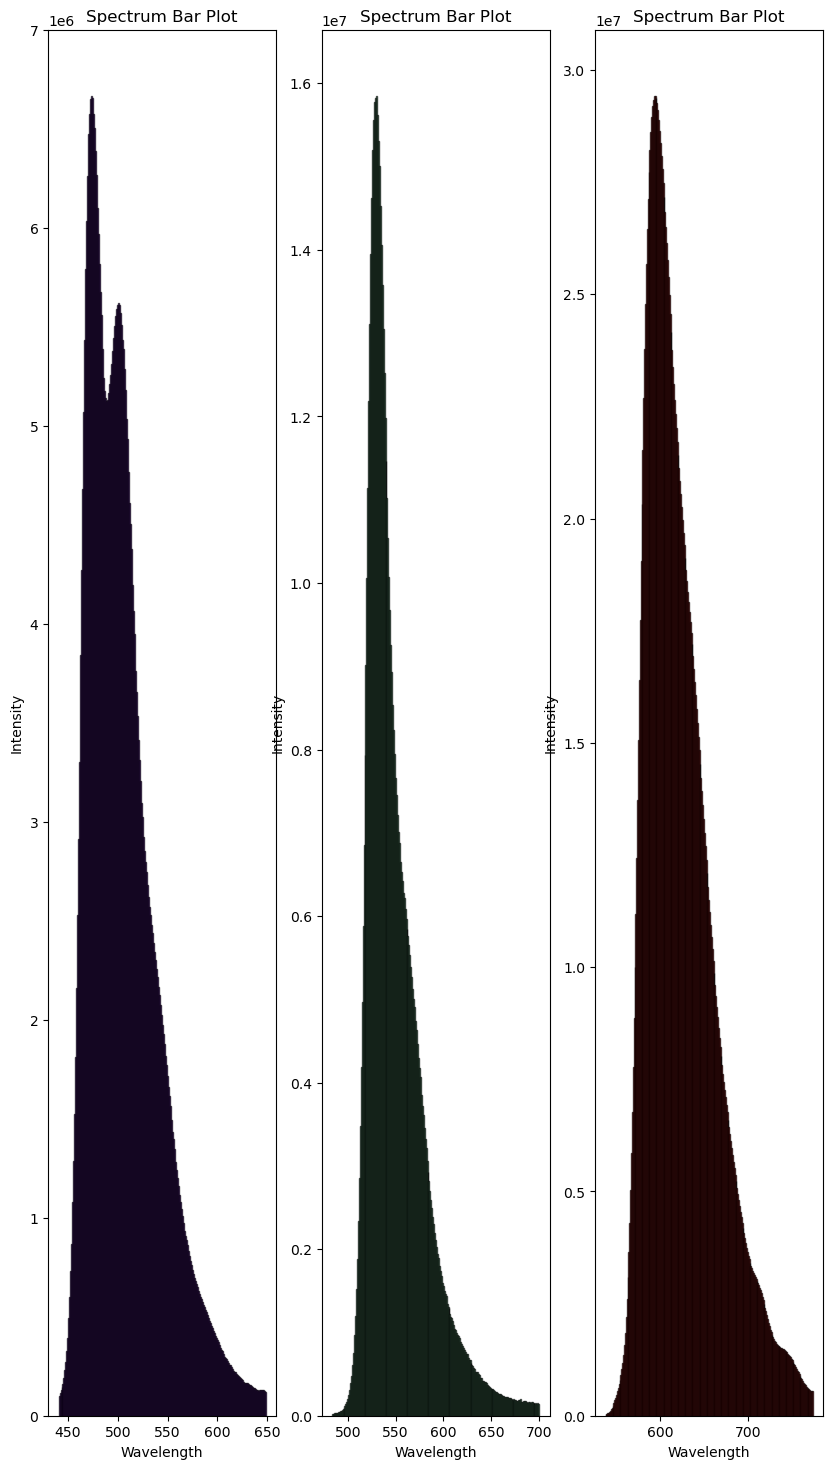

In [15]:
spectrum_plot(em_spectra)

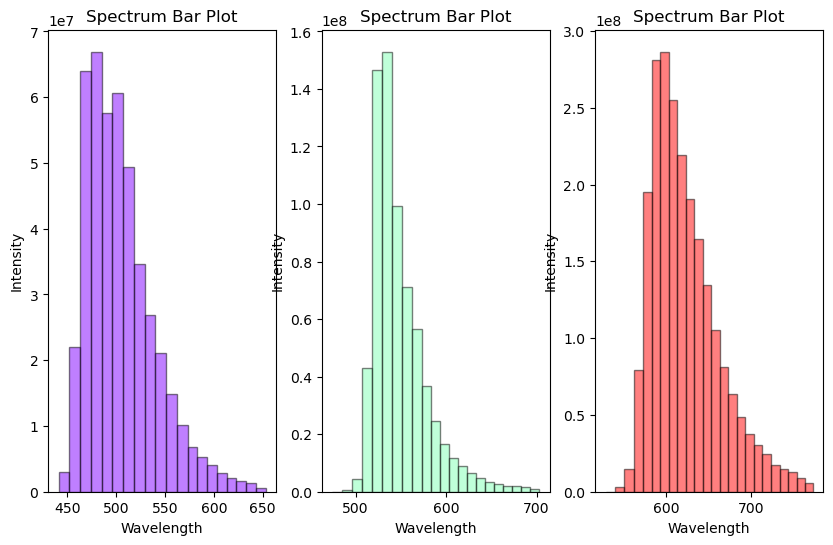

In [16]:
binned_spectrum_plot(em_binned_spectra)

Visualize hyperspectral images using `napari`

We need the following visualizations:
- Each fluorophore separately
- Sum of fluorophores

NOTE: since we have 3D images we used max intensity projections over z-axis.

NOTE: the 3rd dimension will represent the different wavelength bands (i.e., dims are X, Y, W)

In [17]:
# Get the single fluorophore image and the overlapped ones (squeeze channel dimension)
fluor1_em_img = em_img[:, :, 0, ...].squeeze()
fluor2_em_img = em_img[:, :, 1, ...].squeeze()
fluor3_em_img = em_img[:, :, 2, ...].squeeze()
print(fluor1_em_img.shape, fluor2_em_img.shape, fluor3_em_img.shape)

mixed_em_img = np.sum(em_img, axis=2).squeeze()
print(mixed_em_img.shape)

(32, 52, 512, 512) (32, 52, 512, 512) (32, 52, 512, 512)
(32, 52, 512, 512)


In [18]:
# Get MIP images
from microsim.schema.dimensions import Axis

fluor1_em_mip = fluor1_em_img.max(dim=Axis.Z)
fluor2_em_mip = fluor2_em_img.max(dim=Axis.Z)
fluor3_em_mip = fluor3_em_img.max(dim=Axis.Z)
mixed_em_mip = mixed_em_img.max(dim=Axis.Z)

print(fluor1_em_mip.shape, fluor2_em_mip.shape, fluor3_em_mip.shape, mixed_em_mip.shape)

(32, 512, 512) (32, 512, 512) (32, 512, 512) (32, 512, 512)


In [19]:
print(np.max(fluor1_em_mip).values, np.min(fluor1_em_mip).values, fluor1_em_mip.mean().values)
print(np.max(fluor2_em_mip).values, np.min(fluor2_em_mip).values, fluor2_em_mip.mean().values)
print(np.max(mixed_em_mip).values, np.min(mixed_em_mip).values, mixed_em_mip.mean().values)

11041298000.0 0.0 951203000.0
20800508000.0 0.0 2303944400.0
40327107000.0 0.0 4497253000.0


NOTE: intensities should be normalized into a 16bit range before visualization, otherwise we get a saturated image.

Why aren't the intensities not normalized despite the presence of the field validator for the intensity attribute in the pydantic model of the `Spectrum` class?

I guess the normalization triggered by the validator only happens when the spectrum is first initialized. However, in the case of spectra associated to fluorophores, 
we have that after they are obtained from FPbase, they go through several manipulation steps which modify their magnitude.

In [20]:
def normalize_global(data):
    min_val = data.min().item()
    max_val = data.max().item()
    normalized_data = ((data - min_val) / (max_val - min_val) * 65535).astype(np.uint16)
    return normalized_data

In [21]:
norm_fluor1_em_img = normalize_global(fluor1_em_img)
norm_fluor2_em_img = normalize_global(fluor2_em_img)
norm_fluor3_em_img = normalize_global(fluor3_em_img)
norm_mixed_em_img = normalize_global(mixed_em_img)

/localscratch/miniforge3/envs/microsim_env/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:239: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/localscratch/miniforge3/envs/microsim_env/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:239: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/localscratch/miniforge3/envs/microsim_env/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:239: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [22]:
print(np.max(norm_fluor1_em_img).values, np.min(norm_fluor1_em_img).values, norm_fluor1_em_img.values[norm_fluor1_em_img.values != 0.0].mean())
print(np.max(norm_fluor2_em_img).values, np.min(norm_fluor2_em_img).values, norm_fluor2_em_img.values[norm_fluor2_em_img.values != 0.0].mean())
print(np.max(norm_fluor3_em_img).values, np.min(norm_fluor3_em_img).values, norm_fluor3_em_img.values[norm_fluor3_em_img.values != 0.0].mean())
print(np.max(norm_mixed_em_img).values, np.min(norm_mixed_em_img).values, norm_mixed_em_img.values[norm_mixed_em_img.values != 0.0].mean())

65535 0 2156.325473018756
65535 0 2661.1275983814353
65535 0 1279.1604355060408
65535 0 1799.9856881052242


In [23]:
norm_fluor1_em_mip = normalize_global(fluor1_em_mip)
norm_fluor2_em_mip = normalize_global(fluor2_em_mip)
norm_fluor3_em_mip = normalize_global(fluor3_em_mip)
norm_mixed_em_mip = normalize_global(mixed_em_mip)

/localscratch/miniforge3/envs/microsim_env/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:239: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/localscratch/miniforge3/envs/microsim_env/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:239: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/localscratch/miniforge3/envs/microsim_env/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:239: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [24]:
print(np.max(norm_fluor1_em_mip).values, np.min(norm_fluor1_em_mip).values, norm_fluor1_em_mip.values[norm_fluor1_em_mip.values != 0.0].mean())
print(np.max(norm_fluor2_em_mip).values, np.min(norm_fluor2_em_mip).values, norm_fluor2_em_mip.values[norm_fluor2_em_mip.values != 0.0].mean())
print(np.max(norm_fluor3_em_mip).values, np.min(norm_fluor3_em_mip).values, norm_fluor3_em_mip.values[norm_fluor3_em_mip.values != 0.0].mean())
print(np.max(norm_mixed_em_mip).values, np.min(norm_mixed_em_mip).values, norm_mixed_em_mip.values[norm_mixed_em_mip.values != 0.0].mean())

65535 0 5790.916096989286
65535 0 7604.173275317732
65535 0 5594.626078766055
65535 0 7358.006167196783


<xarray.DataArray 'space' ()> Size: 8B
array(0.)
Coordinates:
    f        object 8B distribution=CosemLabel(type='cosem', dataset='jrc_hel...
Attributes:
    space:    axes=(<Axis.Z>, <Axis.Y>, <Axis.X>) shape=(52, 512, 512) scale=...
    unit:     photon/sec
<xarray.DataArray 'space' ()> Size: 8B
array(0.4305807)
Coordinates:
    f        object 8B distribution=CosemLabel(type='cosem', dataset='jrc_hel...
    w        object 8B (507.0, 518.0]
Attributes:
    space:    axes=(<Axis.Z>, <Axis.Y>, <Axis.X>) shape=(52, 512, 512) scale=...
    unit:     photon/sec
<xarray.DataArray 'space' ()> Size: 8B
array(56.8847304)
Coordinates:
    f        object 8B distribution=CosemLabel(type='cosem', dataset='jrc_hel...
    w        object 8B (551.0, 562.0]
Attributes:
    space:    axes=(<Axis.Z>, <Axis.Y>, <Axis.X>) shape=(52, 512, 512) scale=...
    unit:     photon/sec


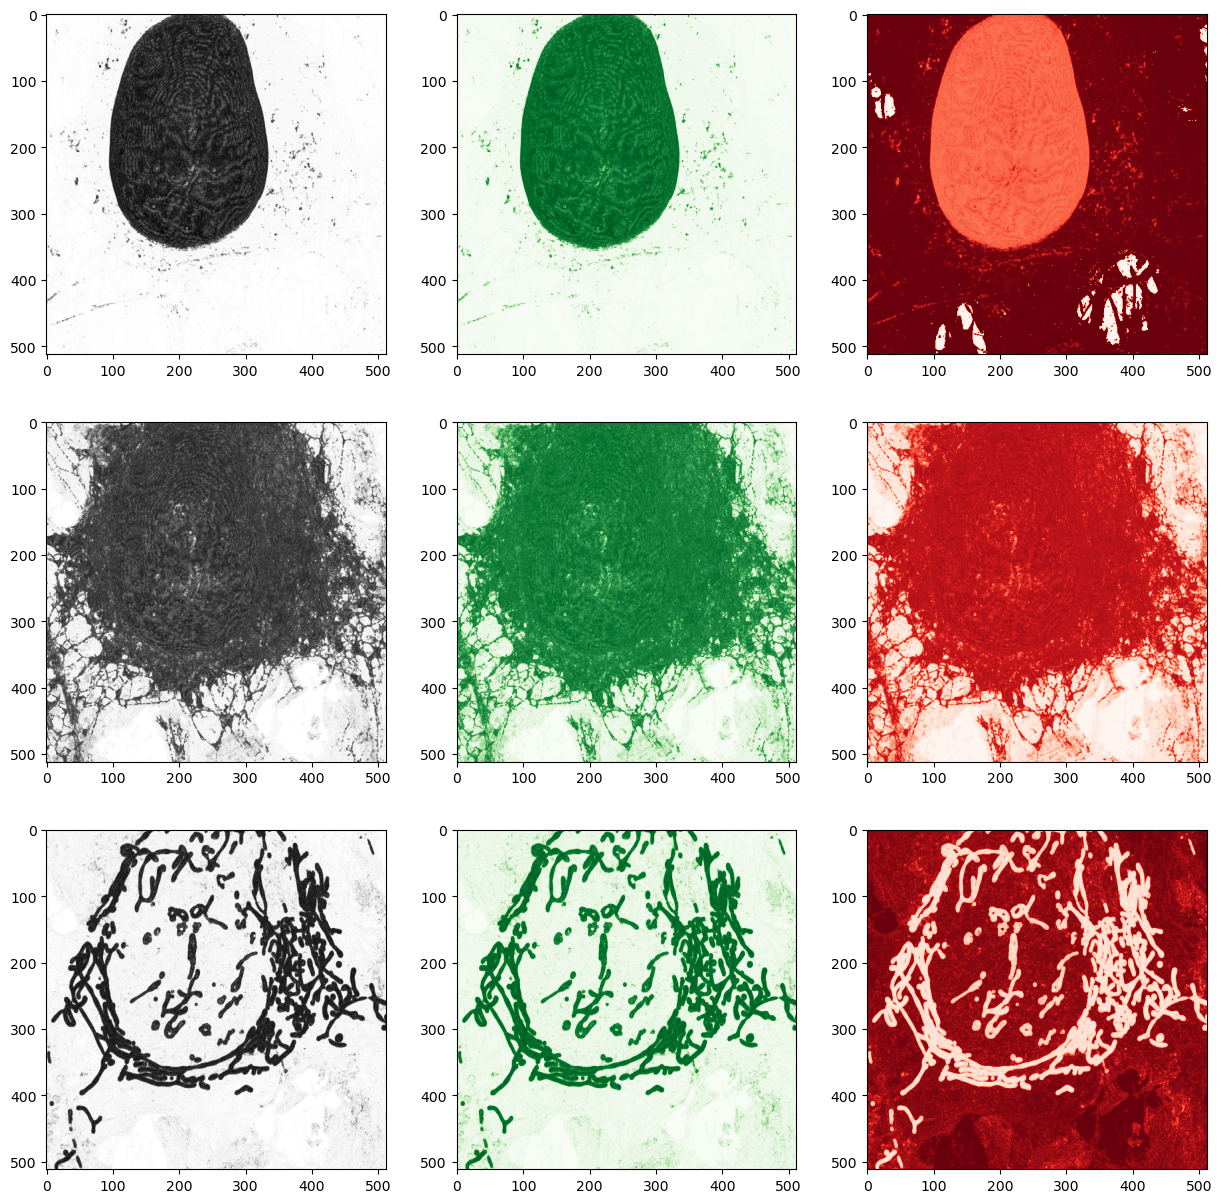

In [25]:
# print(np.all(norm_fluor1_em_img[2, ...] == norm_fluor1_em_img[5, ...] ).item())
# print(np.sum(norm_fluor1_em_img[2, ...] == norm_fluor1_em_img[5, ...]) / sum(norm_fluor1_em_img[2, ...].shape[1:]))
# print(np.sum(norm_fluor1_em_img[2, ...] - norm_fluor1_em_img[5, ...] ) / np.sum(norm_fluor1_em_img[2, ...]))

_, ax = plt.subplots(3, 3, figsize=(15, 15))
ax[0,0].imshow(norm_fluor1_em_mip[1, ...], cmap="Grays")
ax[0,1].imshow(norm_fluor1_em_mip[5, ...], cmap="Greens")
ax[0,2].imshow(abs(norm_fluor1_em_mip[1, ...] - norm_fluor1_em_mip[5, ...]), cmap="Reds")
ax[1,0].imshow(norm_fluor2_em_mip[6, ...], cmap="Grays")
ax[1,1].imshow(norm_fluor2_em_mip[13, ...], cmap="Greens")
ax[1,2].imshow(abs(norm_fluor2_em_mip[6, ...] - norm_fluor2_em_mip[13, ...]), cmap="Reds")
ax[2,0].imshow(norm_fluor3_em_mip[10, ...], cmap="Grays")
ax[2,1].imshow(norm_fluor3_em_mip[14, ...], cmap="Greens")
ax[2,2].imshow(abs(norm_fluor3_em_mip[10, ...] - norm_fluor3_em_mip[14, ...]), cmap="Reds")

print(np.sum(abs(norm_fluor1_em_mip[1, ...] - norm_fluor1_em_mip[1, ...])) / np.sum(norm_fluor1_em_mip[2, ...]))
print(np.sum(abs(norm_fluor2_em_mip[6, ...] - norm_fluor2_em_mip[13, ...])) / np.sum(norm_fluor2_em_mip[6, ...]))
print(np.sum(abs(norm_fluor3_em_mip[10, ...] - norm_fluor3_em_mip[14, ...])) / np.sum(norm_fluor3_em_mip[10, ...]))

In [27]:
import napari

viewer = napari.Viewer()
viewer.add_image(norm_fluor1_em_mip, name="Fluorophore 1", colormap="blue", blending="additive",  contrast_limits=(0, 65535))
viewer.add_image(norm_fluor2_em_mip, name="Fluorophore 2", colormap="yellow", blending="additive",  contrast_limits=(0, 65535))
viewer.add_image(norm_fluor3_em_mip, name="Fluorophore 3", colormap="red", blending="additive",  contrast_limits=(0, 65535))
viewer.add_image(norm_mixed_em_mip, name="Mixed", blending="additive",  contrast_limits=(0, 65535))

# viewer.add_image(norm_fluor1_em_img, name="Fluorophore 1", colormap="blue", blending="additive")
# viewer.add_image(norm_fluor2_em_img, name="Fluorophore 2", colormap="yellow", blending="additive")
# viewer.add_image(norm_fluor3_em_img, name="Fluorophore 3", colormap="red", blending="additive")
# viewer.add_image(norm_mixed_em_img, name="Mixed", blending="additive")

<Image layer 'Mixed' at 0x7feb809a7150>

### Towards Hyperspectral images

#### Approach 1: Given binned data in W bins, find a mapping between this and a smaller binning with W' bins 

The emission spectrum has now shape `(W, C, F, Z, Y, X)`. We assume for simplicity to have a single frequency channels, namely `C=1`.

Our aim here is double:
1. First, for each fluorophore separately (i.e., along `Axis.F`), we want to re-bin the wavelengths in order to get `W'=32` bands. Therefore, this step provides the ground truth *unmixed* images.
2. Then, we justappose (i.e., sum) along the fluorophore dimension to get the *mixed* spectral image.

After this step we will have the *mixed* spectral image of shape `(W', C, Z, X, Y)`, and the *unmixed* ones (ground truth).

NOTE: it is useful to have `W >> W'`.

In [129]:
img = emission_imgs[0]
img.shape, img.coords, type(img)

((183, 1, 2, 64, 256, 256),
 Coordinates:
   * x        (x) float64 2kB 0.0 0.02 0.04 0.06 0.08 ... 5.02 5.04 5.06 5.08 5.1
   * y        (y) float64 2kB 0.0 0.02 0.04 0.06 0.08 ... 5.02 5.04 5.06 5.08 5.1
   * z        (z) float64 512B 0.0 0.04 0.08 0.12 0.16 ... 2.4 2.44 2.48 2.52
   * w        (w) object 1kB (463.0, 475.0] (475.0, 479.0] ... (691.0, 700.0]
   * f        (f) object 16B distribution=MatsLines(type='matslines', density=...,
 xarray.core.dataarray.DataArray)

In [130]:
intervals = img["w"].values
# intervals, type(intervals[0])

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from microsim.schema.dimensions import Axis

def reduce_bins(
    da: xr.DataArray, 
    W_new: int = 32
) -> xr.DataArray:
    
    W, C, F, Z, Y, X = da.shape
    assert W_new < W, f"The new number of bins W'={W_new} must be smaller than the original number of bins W={W}"
    
    old_intervals = da[Axis.W].values
    
    # Initialize the new data array
    new_data = np.zeros((W_new, C, F, Z, Y, X))

    # Calculate the size of new bins and define new intervals
    start, end = old_intervals[0].left, old_intervals[-1].right
    bin_size = (end - start) // (W_new + 1)
    # NOTE: new biins should be the result of merging old bind, since we want to keep the same delimiters
    new_intervals = pd.IntervalIndex.from_breaks(
        # np.linspace(start, end, W_new + 1),
        np.arange(start, end, step=bin_size), 
        closed='right'
    )
    # Set the right value of the last interval to the end value of the spectrum
    last_interval = pd.Interval(left=new_intervals[-1].left, right=end, closed="right")
    new_intervals = [interval for interval in new_intervals[:-1]] + [last_interval]

    # Merge intervals
    for i in range(W_new):
        start = int(i * bin_size)
        end = int((i + 1) * bin_size) if i != W_new - 1 else W
        new_data[i] = da[start:end].sum(dim=Axis.W)

    # Create new DataArray with the reduced bins
    new_da = xr.DataArray(
        new_data, 
        coords=[new_intervals, da.coords[Axis.C], da.coords[Axis.F], da.coords[Axis.Z], da.coords[Axis.Y], da.coords[Axis.X]],
        dims=[Axis.W, Axis.C, Axis.F, Axis.Z, Axis.Y, Axis.X]
    )

    return new_da

In [136]:
import pandas as pd
import math

def rebin(original_bins, new_bin_count):
    
    original_bin_count = len(original_bins)
    
    if new_bin_count > original_bin_count:
        raise ValueError("New bin count must be less than or equal to the original bin count.")
    
    bins_per_new_bin = original_bin_count / new_bin_count
    new_bins = []
    
    start_idx = 0
    for i in range(new_bin_count):
        end_idx = min(math.ceil((i + 1) * bins_per_new_bin), original_bin_count)
        start_bin = original_bins[start_idx]
        end_bin = original_bins[end_idx - 1]
        new_bins.append(pd.Interval(left=start_bin.left, right=end_bin.right, closed='right'))
        start_idx = end_idx
    
    return pd.IntervalIndex(new_bins)

In [118]:
# Example usage:
original_bins = pd.IntervalIndex.from_tuples([(0, 2), (2, 5), (5, 8)], closed='right')
new_bin_count = 2
new_bins = rebin(original_bins, new_bin_count)
print(new_bins)

IntervalIndex([(0, 5], (5, 8]], dtype='interval[int64, right]')


In [137]:
new_intervals = rebin(intervals[:10], 7)
print(intervals[:10], len(intervals[:10]))
print(new_intervals, len(new_intervals))

[Interval(463.0, 475.0, closed='right')
 Interval(475.0, 479.0, closed='right')
 Interval(479.0, 481.0, closed='right')
 Interval(481.0, 483.0, closed='right')
 Interval(483.0, 484.0, closed='right')
 Interval(484.0, 485.0, closed='right')
 Interval(484.0, 501.0, closed='right')
 Interval(485.0, 486.0, closed='right')
 Interval(486.0, 487.0, closed='right')
 Interval(487.0, 488.0, closed='right')] 10
IntervalIndex([(463.0, 479.0], (479.0, 481.0], (481.0, 484.0], (484.0, 485.0],
               (484.0, 486.0], (486.0, 487.0], (487.0, 488.0]],
              dtype='interval[float64, right]') 7


In [85]:
# A small test to check the function
# data = np.array(
#     [[
#         [[[[1, 1, 1], [1, 1, 1], [1, 1, 1]]], 
#         [[[1, 1, 1], [1, 1, 1], [1, 1, 1]]]]
#     ], 
#     [
#         [[[[1, 1, 1], [1, 1, 1], [1, 1, 1]]], 
#         [[[1, 1, 1], [1, 1, 1], [1, 1, 1]]]]
#     ], 
#     [
#         [[[[1, 1, 1], [1, 1, 1], [1, 1, 1]]], 
#         [[[1, 1, 1], [1, 1, 1], [1, 1, 1]]]]
#     ]]
# )
# OR
W, C, F, Z, Y, X = 9, 1, 2, 1, 3, 3  # Original dimensions
data = np.ones((W, C, F, Z, Y, X))
print(data.shape)

# Define bins as pandas interval objects
intervals = pd.IntervalIndex.from_breaks(range(W + 1), closed='right')
print(intervals)

# Create the xarray.DataArray
da = xr.DataArray(
    data, 
    coords=[intervals, range(C), range(F), range(Z), range(Y), range(X)], 
    dims=[Axis.W, Axis.C, Axis.F, Axis.Z, Axis.Y, Axis.X]
)

# Reduce the bins to W' where W' < W
W_new = 2  # Example: reduce to 4 bins
new_da = reduce_bins(da, W_new)

# Print shapes
print("Original shape:", da.shape)
print("New shape:", new_da.shape)

(9, 1, 2, 1, 3, 3)
IntervalIndex([(0, 1], (1, 2], (2, 3], (3, 4], (4, 5], (5, 6], (6, 7], (7, 8],
               (8, 9]],
              dtype='interval[int64, right]')
Original shape: (9, 1, 2, 1, 3, 3)
New shape: (2, 1, 2, 1, 3, 3)


In [86]:
new_da

<xarray.DataArray (w: 2, c: 1, f: 2, z: 1, y: 3, x: 3)> Size: 288B
array([[[[[[4., 4., 4.],
           [4., 4., 4.],
           [4., 4., 4.]]],


         [[[4., 4., 4.],
           [4., 4., 4.],
           [4., 4., 4.]]]]],




       [[[[[5., 5., 5.],
           [5., 5., 5.],
           [5., 5., 5.]]],


         [[[5., 5., 5.],
           [5., 5., 5.],
           [5., 5., 5.]]]]]])
Coordinates:
  * w        (w) object 16B (0, 4] (4, 9]
  * c        (c) int64 8B 0
  * f        (f) int64 16B 0 1
  * z        (z) int64 8B 0
  * y        (y) int64 24B 0 1 2
  * x        (x) int64 24B 0 1 2

In [108]:
# Test on the real data
# sliced_img = img[:5, ...]
# sliced_img_reduced = reduce_bins(sliced_img, W_new=3)
img_reduced = reduce_bins(img, W_new=32)
img_reduced.shape, img_reduced.coords[Axis.W]

7.181818181818182 7.40625 7.645161290322581
33 32
IntervalIndex([(463.0, 470.0], (470.0, 477.0], (477.0, 484.0], (484.0, 491.0],
               (491.0, 498.0], (498.0, 505.0], (505.0, 512.0], (512.0, 519.0],
               (519.0, 526.0], (526.0, 533.0], (533.0, 540.0], (540.0, 547.0],
               (547.0, 554.0], (554.0, 561.0], (561.0, 568.0], (568.0, 575.0],
               (575.0, 582.0], (582.0, 589.0], (589.0, 596.0], (596.0, 603.0],
               (603.0, 610.0], (610.0, 617.0], (617.0, 624.0], (624.0, 631.0],
               (631.0, 638.0], (638.0, 645.0], (645.0, 652.0], (652.0, 659.0],
               (659.0, 666.0], (666.0, 673.0], (673.0, 680.0], (680.0, 687.0],
               (687.0, 694.0]],
              dtype='interval[float64, right]')
33
[Interval(463.0, 470.0, closed='right'), Interval(470.0, 477.0, closed='right'), Interval(477.0, 484.0, closed='right'), Interval(484.0, 491.0, closed='right'), Interval(491.0, 498.0, closed='right'), Interval(498.0, 505.0, closed='rig

ValueError: conflicting sizes for dimension <Axis.W>: length 32 on the data but length 33 on coordinate <Axis.W>

In [142]:
print(img[5, :, 0, ...].sum().values)
print(img[5, :, 1, ...].sum().values)
print(img[6, :, 0, ...].sum().values)
print(img[6, :, 1, ...].sum().values)

17746463000.0
0.0
0.0
4451190000.0


#### Approach 2: In `Simulation.emission_flux()` replace the `"equal_area"` binning with equispaced bins

In [16]:
from typing import NamedTuple

class Bin(NamedTuple):
    # TODO : include units for each of these. Use pint.
    """One interval."""

    start: float
    end: float
    mean: float | None = None
    mode: float | None = None

    def __contains__(self, x: object) -> bool:
        try:
            return self.start <= x <= self.end  # type: ignore
        except TypeError:
            return False

    def __str__(self) -> str:
        if self.start is not None:
            assert self.end is not None
            return f"[{self.start:.2f}-{self.end:.2f}]"
        elif self.mean is not None:
            return f"Mean:{self.mean:.2f}"
        else:
            assert self.mode is not None
            return f"Mode:{self.mode:.2f}"


def _generate_bins_equal_space(
    x: np.ndarray, 
    num_bins: int
) -> list[tuple[int, int]]:
    """
    Split the range of values in x into num_bins equally spaced bins.
    If len(x) is not divisible by num_bins, the last bin will have more elements.
    """
    bins = []
    start = 0
    bin_size = len(x) // num_bins
    for i in range(num_bins):
        end = start + bin_size
        bins.append(Bin(start=x[start], end=x[end]))
        start = end
        
    if bins[-1].end != x[-1]:
        bins[-1] = Bin(start=bins[-1].start, end=x[-1])
        
    return bins

arr = np.arange(463.0, 701., 1)
bins = _generate_bins_equal_space(arr, 32)
bins, len(bins) 

1